# Visualization of PDGFR-ꞵ and PDGFR-α in defined ROIs

This notebook provides a pipeline for the 3D rendering of PDGFR-ꞵ and PDGFR-α in defined brain regions. The files are loaded from a specific path and then rendered in a separate window. The last line allows to save the last rendering in a defined path.

## Load libraries

We load the required libraries for the whole pipeline. 

In [1]:
import numpy as np
import  imageio
import vtk
from vtk.util import numpy_support
from vtk import vtkImageThreshold, vtkMarchingCubes
from vtk import vtkImageGaussianSmooth

## Functions

We defined the functions for normalizing the image histograms, volumtric and solid rendering. 

### Load and Normalize Image

In [2]:
def load_and_normalize(image_path):
    image_data = imageio.volread(image_path)
    normalized = (image_data - np.min(image_data)) / (np.max(image_data) - np.min(image_data)) * 255
    return normalized.astype(np.uint8)


 ### Volumetric Rendering Function

In [3]:
def volume_rendering(image_data, color, max_opacity=0.9):
    # Convert the image data to vtkImageData
    data_array = numpy_support.numpy_to_vtk(num_array=image_data.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
    image_data_vtk = vtk.vtkImageData()
    image_data_vtk.SetDimensions(image_data.shape[2], image_data.shape[1], image_data.shape[0])
    image_data_vtk.SetSpacing(1, 1, 150/16)  # Adjust Z-spacing here
    image_data_vtk.GetPointData().SetScalars(data_array)
    
    # Define color transfer function
    color_func = vtk.vtkColorTransferFunction()
    if color == "red":
        color_func.AddRGBPoint(0, 0.0, 0.0, 0.0)  # Black for 0 intensity
        color_func.AddRGBPoint(50, 1.0, 0.0, 0.0)  # Red for maximum intensity
    elif color == "green":
        color_func.AddRGBPoint(0, 0.0, 0.0, 0.0)  # Black for 0 intensity
        color_func.AddRGBPoint(150, 0.0, 1.0, 0.0)  # Green for maximum intensity
    
    # Define opacity transfer function
    opacity_func = vtk.vtkPiecewiseFunction()
    opacity_func.AddPoint(0, 0)  # Fully transparent for 0 intensity
    opacity_func.AddPoint(100, max_opacity)  # Adjusted opacity for maximum intensity

    # Set volume properties
    volume_property = vtk.vtkVolumeProperty()
    volume_property.SetColor(color_func)
    volume_property.SetScalarOpacity(opacity_func)
    
    # Create a volume and mapper
    volume = vtk.vtkVolume()
    volume.SetProperty(volume_property)

    mapper = vtk.vtkSmartVolumeMapper()
    mapper.SetInputData(image_data_vtk)
    mapper.SetInterpolationModeToLinear()  # Set interpolation mode to linear

    volume.SetMapper(mapper)

    return volume

### Solid Rendering Function

In [4]:
def solid_rendering(image_data, color, threshold_value):
    # Convert the image data to vtkImageData
    data_array = numpy_support.numpy_to_vtk(num_array=image_data.ravel(), deep=True, array_type=vtk.VTK_UNSIGNED_CHAR)
    image_data_vtk = vtk.vtkImageData()
    image_data_vtk.SetDimensions(image_data.shape[2], image_data.shape[1], image_data.shape[0])
    image_data_vtk.SetSpacing(1, 1, 100/16)  # Adjust Z-spacing here
    image_data_vtk.GetPointData().SetScalars(data_array)

    # Apply the threshold
    threshold_filter = vtk.vtkImageThreshold()
    threshold_filter.SetInputData(image_data_vtk)
    threshold_filter.ThresholdByLower(threshold_value)
    threshold_filter.ReplaceInOn()
    threshold_filter.SetInValue(0)
    threshold_filter.ReplaceOutOn()
    threshold_filter.SetOutValue(1)
    threshold_filter.Update()

    # Generate the surface
    surface_extractor = vtk.vtkMarchingCubes()
    surface_extractor.SetInputConnection(threshold_filter.GetOutputPort())
    surface_extractor.SetValue(0, 1)

    # Smooth the surface
    smoother = vtk.vtkWindowedSincPolyDataFilter()
    smoother.SetInputConnection(surface_extractor.GetOutputPort())
    smoother.SetNumberOfIterations(10)
    smoother.NonManifoldSmoothingOn()
    smoother.NormalizeCoordinatesOn()
    smoother.GenerateErrorScalarsOn()
    smoother.Update()

    # Map the smoothed data to a surface
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(smoother.GetOutputPort())
    mapper.ScalarVisibilityOff()  # Turn off scalar visibility to ensure the specified color is used

    # Create an actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    # Define the color
    if color == "green":
        actor.GetProperty().SetColor(1, 0, 0)
    elif color == "red":
        actor.GetProperty().SetColor(0, 1, 0)
    else:
        actor.GetProperty().SetColor(0, 0, 1)  # Default to blue if neither red nor green is specified

    return actor

## Load and normalize the images

We provide a specific path to load a pair of PDGFR-ꞵ and PDGFR-α z-stacks.

In [13]:
first_image_path = r'E:/Research/Stroke_PDGFRb_Reactivity/Exp4-Pdgfra-Pdgfrb/Widefield_20x_ROIs-Stacks_Pdgfra-Pdgfrb/Images_StacksChannels/Td012_7D_MCAO_L1_Peri_Pdgfra.tif'
second_image_path = r'E:/Research/Stroke_PDGFRb_Reactivity/Exp4-Pdgfra-Pdgfrb/Widefield_20x_ROIs-Stacks_Pdgfra-Pdgfrb/Images_StacksChannels/Td012_7D_MCAO_L1_Peri_Pdgfrb.tif'

"E:\Research\Stroke_PDGFRb_Reactivity\Exp4-Pdgfra-Pdgfrb\Widefield_20x_ROIs-Stacks_Pdgfra-Pdgfrb\Images_StacksChannels\Td012_7D_MCAO_L1_Ctx_Pdgfra.tif"
first_image_data = load_and_normalize(first_image_path)
second_image_data = load_and_normalize(second_image_path)

## Visual inspection

We perform a visual inpecton of the histograms to estimate the intensity distributions.

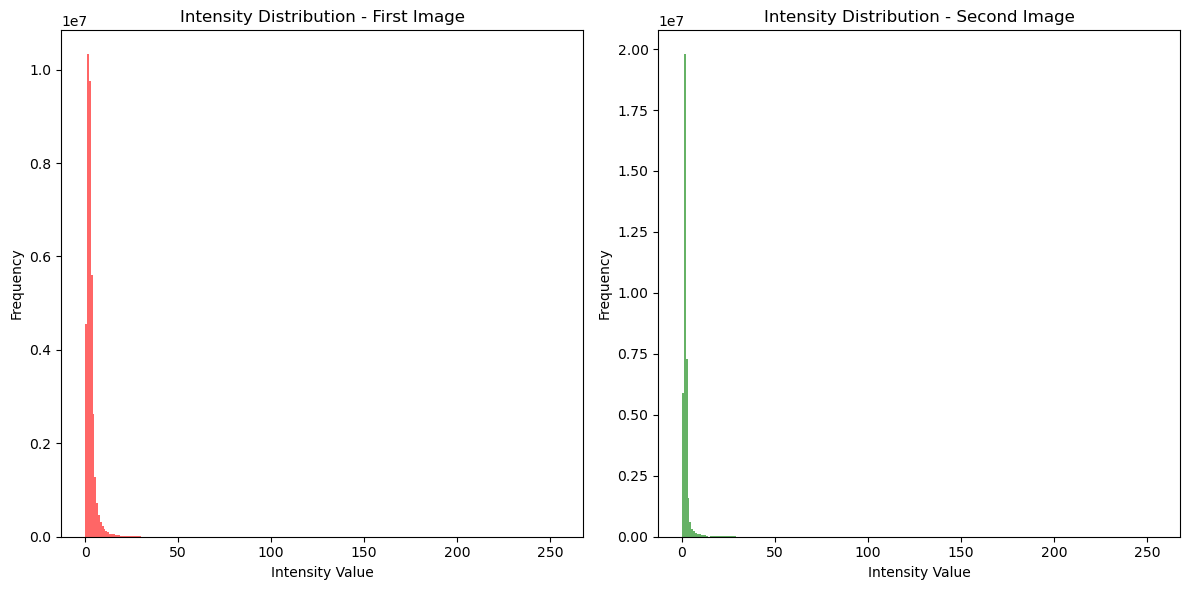

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.hist(first_image_data.ravel(), bins=256, color='red', alpha=0.6)
plt.title('Intensity Distribution - First Image')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(second_image_data.ravel(), bins=256, color='green', alpha=0.6)
plt.title('Intensity Distribution - Second Image')
plt.xlabel('Intensity Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

And then perform a visual inspection of different z positions to verify the image content. 

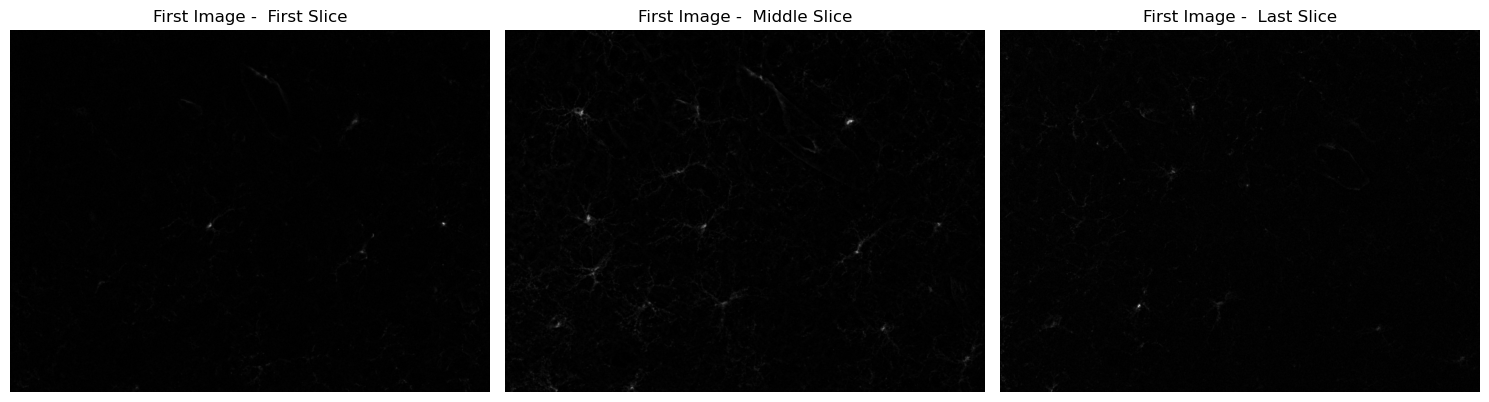

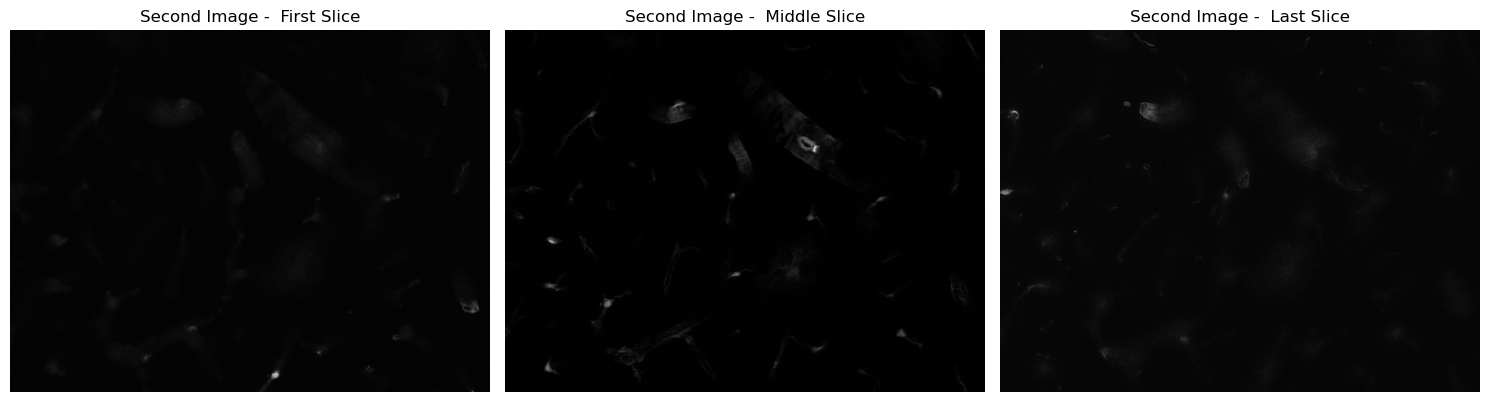

In [15]:
import matplotlib.pyplot as plt

def visualize_slices(image_data, title_prefix=''):
    """Visualize the first, middle, and last slice of the provided image data."""
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(image_data[0], cmap='gray')
    axes[0].set_title(f'{title_prefix} First Slice')
    axes[0].axis('off')

    axes[1].imshow(image_data[image_data.shape[0] // 2], cmap='gray')
    axes[1].set_title(f'{title_prefix} Middle Slice')
    axes[1].axis('off')

    axes[2].imshow(image_data[-1], cmap='gray')
    axes[2].set_title(f'{title_prefix} Last Slice')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

# After loading and preprocessing the images
visualize_slices(first_image_data, title_prefix='First Image - ')
visualize_slices(second_image_data, title_prefix='Second Image - ')

## Main Execution

Here, we excecute the rendering functions to generate a separate window with the 3D rendering of PDGFR-ꞵ and combined PDGFR-ꞵ/PDGFR-α

In [20]:
# Load images using imageio
first_image = imageio.imread(first_image_path)
second_image = imageio.imread(second_image_path)

# Normalize the images to 8-bit (0-255)
first_image_normalized = ((first_image - first_image.min()) * (255.0 / (first_image.max() - first_image.min()))).astype(np.uint8)
second_image_normalized = ((second_image - second_image.min()) * (255.0 / (second_image.max() - second_image.min()))).astype(np.uint8)

# Create the volume renderings with specified opacities
first_image_vtk_volume = volume_rendering(first_image_normalized, "green", max_opacity=0.9)
second_image_vtk_volume = volume_rendering(second_image_normalized, "red", max_opacity=0.9)

first_threshold = 10  # Adjust as needed
second_threshold = 10  # Adjust as needed

first_image_solid_actor = solid_rendering(first_image_data, "red", first_threshold)
second_image_solid_actor = solid_rendering(second_image_data, "green", second_threshold)

# Set up the combined visualization for volume rendering
renderer_volume = vtk.vtkRenderer()
renderer_volume.AddVolume(first_image_vtk_volume)
renderer_volume.AddVolume(second_image_vtk_volume)

# Set up the combined visualization for solid rendering
renderer_solid = vtk.vtkRenderer()
renderer_solid.AddActor(first_image_solid_actor)
renderer_solid.AddActor(second_image_solid_actor)

# Create the rendering window and interactor for volume rendering
render_win_volume = vtk.vtkRenderWindow()
render_win_volume.AddRenderer(renderer_volume)
render_win_interactor_volume = vtk.vtkRenderWindowInteractor()
render_win_interactor_volume.SetRenderWindow(render_win_volume)

# Create the rendering window and interactor for solid rendering
render_win_solid = vtk.vtkRenderWindow()
render_win_solid.AddRenderer(renderer_solid)
render_win_interactor_solid = vtk.vtkRenderWindowInteractor()
render_win_interactor_solid.SetRenderWindow(render_win_solid)

# Set the background color and window size for both renderings
renderer_volume.SetBackground(0, 0, 0)
render_win_volume.SetSize(800, 600)

renderer_solid.SetBackground(0, 0, 0)
render_win_solid.SetSize(800, 600)

# Start the rendering loop for volume rendering
render_win_volume.Render()
render_win_interactor_volume.Start()

# Start the rendering loop for solid rendering
render_win_solid.Render()
render_win_interactor_solid.Start()


C:\Users\danie\AppData\Local\Temp\ipykernel_21008\1911639982.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  first_image = imageio.imread(first_image_path)
C:\Users\danie\AppData\Local\Temp\ipykernel_21008\1911639982.py:3: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  second_image = imageio.imread(second_image_path)


## Save the image

If required, the user can set the camera position and save the images in a specific path by modifying the `save_solid_rendering_as_image` function.


In [17]:
camera = renderer_solid.GetActiveCamera()
camera.SetPosition(10, 10, 10)
camera.SetFocalPoint(10, 10, 10)
camera.SetViewUp(10, 10, 10)

In [19]:
def save_solid_rendering_as_image(filename, width, height, elevation_angle, azimuthal_angle):
    # Set up the renderer
    renderer = vtk.vtkRenderer()

    # Add the two actors (3D objects) to the renderer
    renderer.AddActor(first_image_solid_actor)
    renderer.AddActor(second_image_solid_actor)

    # Set the background color
    renderer.SetBackground(0, 0, 0)  # Black

    # Set up the render window
    render_window = vtk.vtkRenderWindow()
    render_window.SetOffScreenRendering(1)  # Enable off-screen rendering so we don't need a UI window
    render_window.AddRenderer(renderer)
    render_window.SetSize(width, height)  # Set the size of the saved image

    # Set up the render window interactor
    render_window_interactor = vtk.vtkRenderWindowInteractor()
    render_window_interactor.SetRenderWindow(render_window)

    # Adjust the camera angle
    camera = renderer.GetActiveCamera()
    camera.Elevation(20)  # Adjust the up-down angle (positive values look from above)
    camera.Azimuth(-20)  # Adjust the left-right angle

    # Render the scene
    renderer.ResetCamera()  # Adjust the camera parameters so the whole scene fits in the view
    render_window.Render()

    # Save the rendering to an image file
    window_to_image_filter = vtk.vtkWindowToImageFilter()
    window_to_image_filter.SetInput(render_window)
    window_to_image_filter.Update()

    writer = vtk.vtkPNGWriter()
    writer.SetFileName(filename)
    writer.SetInputConnection(window_to_image_filter.GetOutputPort())
    writer.Write()

# Save the image
save_solid_rendering_as_image("D:/Research/Stroke_PDGFR-B_Reactivity/Images\Widefield_20x_ROIs_Pdgfrb-Pdgfra_Volumes/solid_rendering2.png", 1600, 1200, 45, 45)
